In [7]:
import jax
import jax.numpy as np
from jax.random import PRNGKey, multivariate_normal, normal
from scipy.optimize import minimize

import matplotlib.pyplot as plt

key = PRNGKey(42)

Генерация данных происходит следующим образом. Оптимальные веса имеют нормальное априорное распределение $\textbf{w} \sim \mathcal{N}(0,\mathbf{A}^{−1})$, а целевая переменная $\mathbf{y} \sim \mathcal{N}(\textbf{Xw}, \mathbf{B}^{-1})$, $\textbf{X}$ - выборка объектов. В данной работе рассматривается случай $\mathbf{B} = \beta \mathbf{I}$

In [2]:
def generate_data(A, beta, n = 100):
    # Генерация данных по матрице A и скаляру beta

    w_opt = multivariate_normal(key, np.zeros(3), np.linalg.inv(A))

    x_data = normal(key, shape=(n, 3))
    eps = normal(key, shape=(n, )) / beta ** 0.5

    y_real = x_data @ w_opt + eps

    return w_opt, x_data, y_real

Наша задача по выборке $\mathbf{X}$ и целевой переменной $\mathbf{y}$ определить структурные параметры модели $\mathbf{A}, \beta$ при помощи аппроксимации Лапласа.

Рассмотрим различные случаи матрицы $\mathbf{A}$

## $\textbf{A}$ - диагональная

Тогда следуем согласно алгоритму из статьи $\href{http://strijov.com/papers/HyperOptimizationEng.pdf}{Structure~parameter~estimation~algorithms~for~model ~selection}$.

Инициализировав $\textbf{A} = \textbf{A}_0, \beta = \beta_0$, итеративно повторяем следующие шаги:


1. $\hat{\textbf{w}} = \mathbf{(A + \beta X^T X)^{-1} \beta X^T y}$
2. $\rho = \sum\limits_{j=1}^n \dfrac{\beta h_j}{\alpha_j + \beta h_j}$
3. $\beta = \dfrac{1 - \rho}{|| \mathbf{y - Xw} ||^2}$
4. $a_j = \dfrac{\beta h_j}{2} (-1 + \sqrt{1 + \dfrac{4}{\beta h_j || \textbf{w}||^2}})$

$h_j$ - $j$-е собственное число матрицы  $\mathbf{H = A + \beta X^T X}$

$a_j$ - $j$-е число на диагонали матрицы $\mathbf{A}$



In [19]:
def solve_diagonal(A, b, num_iters=100):
    res = []
    res_b = []

    H_D = x_data.T @ x_data

    for _ in range(num_iters):
        w_hat = b * np.linalg.inv(A + b * H_D) @ x_data.T @ y_real

        a_j = np.diag(A)
        h_j = np.linalg.eig(H_D)[0]

        rho = (b * h_j / (a_j + b * h_j)).sum()
        b = (1 - rho) / ((y_real - x_data @ w_hat) ** 2).sum()

        a_j = b * h_j / 2 * (-1 + np.sqrt(1 + 4 / (b * h_j * (w_hat ** 2).sum())))
        A = np.diag(a_j)

        res.append(np.linalg.norm(A - A_diag))
        res_b.append(np.linalg.norm(b - b_diag))

    return A, b, res, res_b

Зададим истинные параметры

In [20]:
A_diag = np.diag(normal(key, shape=(3,))) ** 2
b_diag = 400

w_opt, x_data, y_real = generate_data(A_diag, b_diag)

Вычислим их аппроксимацию при помощи алгоритма

In [21]:
A, b, res, res_b = solve_diagonal(np.eye(3, 3), 100)

Выведем результат аппроксимации по итерациям

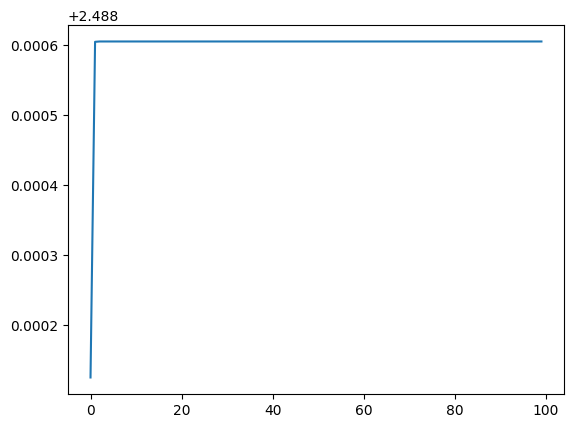

In [22]:
plt.plot(res)

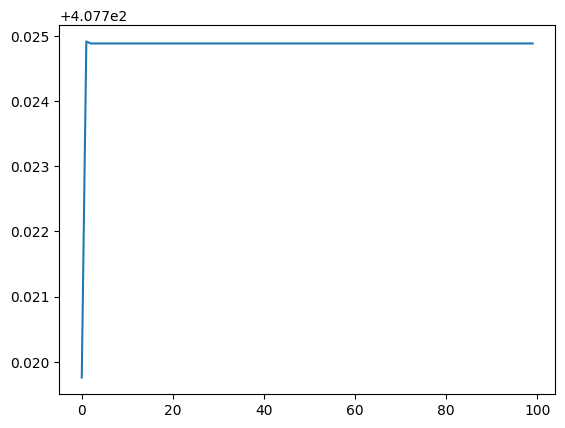

In [23]:
plt.plot(res_b);

Полученные значения

In [24]:
A, b

(Array([[0.33427522-0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.33423346-0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.33423024-0.j]], dtype=complex64),
 Array(-7.7248917+0.j, dtype=complex64))

Истинные значения

In [11]:
A_diag, b_diag

(Array([[0.03494487, 0.        , 0.        ],
        [0.        , 1.6400657 , 0.        ],
        [0.        , 0.        , 2.4314575 ]], dtype=float32),
 400)

Почему-то метод не работает :(

## $\mathbf{A}$ - скалярная ($\alpha \mathbf{I}$)

Тогда алгоритм меняется на:

1. $\hat{\textbf{w}} = \mathbf{(A + \beta X^T X)^{-1} \beta X^T y}$
2. $\gamma = \sum\limits_{j=1}^n \dfrac{\beta h_j}{\alpha + \beta h_j}$
3. $\alpha = \dfrac{\gamma}{|| \textbf{w}||^2}$
4. $\beta = \dfrac{m - \gamma}{|| \mathbf{y - Xw} ||^2}$


In [25]:
def solve_scalar(A, b, num_iters=100):
    res = []
    res_b = []

    H_D = x_data.T @ x_data

    for _ in range(num_iters):
        w_hat = b * np.linalg.inv(A + b * H_D) @ x_data.T @ y_real

        a = A[0, 0]
        h_j = np.linalg.eig(H_D)[0]

        gamma = (b * h_j / (a + b * h_j)).sum()
        b = (3 - gamma) / ((y_real - x_data @ w_hat) ** 2).sum()

        a = gamma / (w_hat ** 2).sum()

        res.append(np.linalg.norm(a - a_scalar))
        res_b.append(np.linalg.norm(b - b_scalar))

    return A, b, res, res_b

In [29]:
a_scalar = 2
b_scalar = 400

w_opt, x_data, y_real = generate_data(np.eye(3) * a_scalar, b_scalar)

In [30]:
A, b, res, res_b = solve_diagonal(np.eye(3, 3), 100)

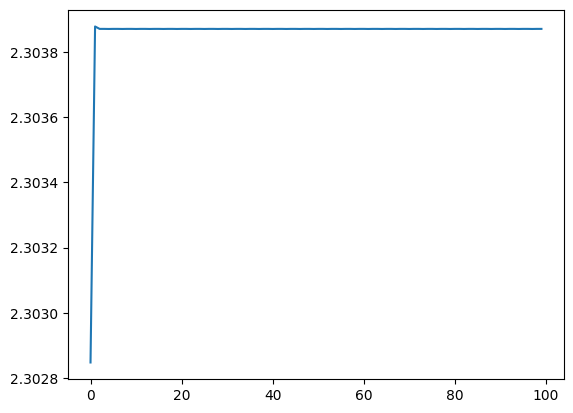

In [31]:
plt.plot(res);

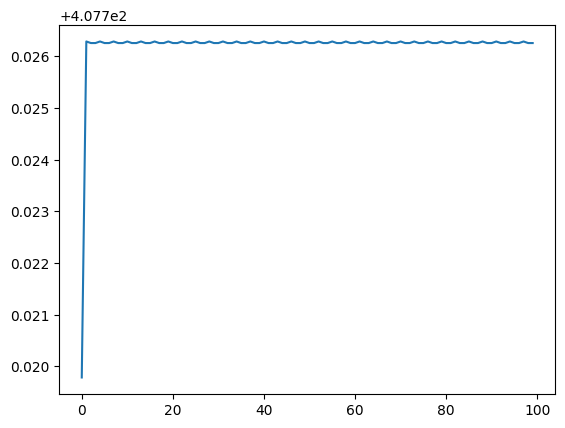

In [32]:
plt.plot(res_b);

Полученные результаты:


In [34]:
A, b

(Array([[0.48846912-0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.48837587-0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.48832974-0.j]], dtype=complex64),
 Array(-7.726271+0.j, dtype=complex64))

Истинные результаты

In [35]:
a_scalar, b_scalar

(2, 400)

Опять ничего не получилось. В какой-то момент матрица просто перестает меняться

## $\mathbf{A}$ - полная

Для этого случая нет алгоритма, поэтому будем искать оптимум градиентным спуском

Необходимо найти решение следующей оптимизационной задачи:

$\mathcal{L}(A, B) = \log|\mathbf{A}| + \log|\mathbf{B}| - \log|\mathbf{H}| \to \max_{\mathbf{A, B}}$

$\mathbf{H = A + \beta X^T X}$

При этом выполним подстановку $A = M^T M$, чтобы $A$ удовлетворяла свойству положительной определенности.

С подстановкой получаем $2 \log|M| + \log \beta - \log| M^TM + \beta X^T X|$

Тогда градиенты равны:

$\nabla \mathcal{L}_{M} = 2 M^{-T} - 2 M (M^T M + \beta X^T X)^{-1}$

$\nabla \mathcal{L}_{\beta} = 1/b - \text{trace}(X^T X (M^TM + \beta X^T X))$

In [61]:
def solve_full(M, b, num_iters=2000, alpha=1e-2):
    res = []
    res_b = []
    H_D = x_data.T @ x_data

    for _ in range(num_iters):
        MM = M.T @ M

        M = M - alpha * ((2 * np.linalg.inv(M)).T - 2 * M @ np.linalg.inv(MM + b * H_D))
        b = b - alpha * (1/b - np.trace(H_D @ np.linalg.inv(MM + b * H_D)))

        res.append(np.linalg.norm(M.T @ M - A_full))
        res_b.append(np.linalg.norm(b - b_full))

    return M.T @ M, b, res, res_b

In [44]:
M = normal(key, shape=(3, 3))
A_full = M.T @ M

b_full = 400
B_full = b_full * np.eye(3) # w dist

w_opt, x_data, y_real = generate_data(A_full, b_full)

In [62]:
A, b, res, res_b = solve_full(np.eye(3, 3), 100)

Полученные результаты

In [65]:
A, b

(Array([[ 96.51668  ,   8.849912 , -19.608501 ],
        [  8.849912 ,  39.10898  ,  -6.6307755],
        [-19.608501 ,  -6.6307755,  28.993555 ]], dtype=float32),
 Array(100.39673, dtype=float32))

Истинные значения

In [51]:
A_full, b_full

(Array([[ 1.7544435 ,  0.81703043, -1.5054854 ],
        [ 0.81703043,  1.0135221 , -0.3460476 ],
        [-1.5054854 , -0.3460476 ,  1.6201866 ]], dtype=float32),
 400)

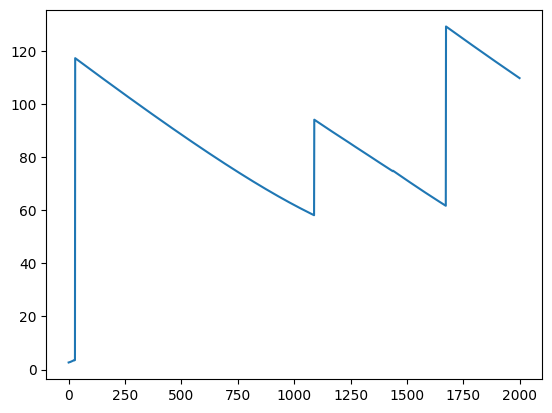

In [63]:
plt.plot(res);

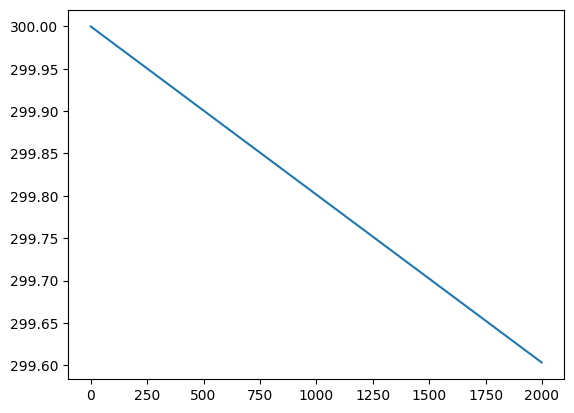

In [64]:
plt.plot(res_b);

Видно, что $\beta$ мало меняется со временем. А решение для матрицы $A$ постепенно приближается к истинному значению, но затем скачком отдаляется

Получилось, что ничего не получилось